## Analyze A/B Test Results
~Irish Mehta



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [References](#references)

<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [211]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.

a. Read in the dataset and take a look at the top few rows here:

In [212]:
df= pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [213]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [214]:
df['user_id'].nunique()

290584

In [215]:
df['converted'].unique()

array([0, 1])

d. The proportion of users converted.

In [216]:
(df['converted']==1).mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [217]:
df[(df['landing_page']== 'new_page') & (df['group']!='treatment')].count()[0] + df[(df['landing_page']!= 'new_page') & (df['group']=='treatment')].count()[0]

3893

f. Do any of the rows have missing values?

In [218]:
null_data = df[df.isnull().any(axis=1)]
null_data.count()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [219]:
df2= df[((df['group']=='treatment') & (df['landing_page']=='new_page')) | ((df['group']=='control') & (df['landing_page']=='old_page'))]  

In [220]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [221]:
df2.shape

(290585, 5)

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [222]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [223]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [224]:
df2 = df2.drop_duplicates('user_id')

In [225]:
df2.shape

(290584, 5)

`4.` Use **df2** in the cells below 

a. What is the probability of an individual converting regardless of the page they receive?

In [226]:
(df2['converted']==1).mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [227]:
(((df2['group']== 'control') & (df2['converted']==1)).mean())/(df2['group']== 'control').mean() 

0.12038630450046119

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [228]:
(((df2['group']== 'treatment') & (df2['converted']==1)).mean())/(df2['group']== 'treatment').mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [229]:
(df2['landing_page']=='new_page').mean()

0.50006194422266881

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

*Looking at the probability of conversion of the treatment group, it does not seem that the new page is very effective in terms of conversions as the probability of conversion of the control group is more or less similar to the probability of conversion of the treatment group. The purpose of creating a new treatment page is so that the conversion of users increases, but in this case it is not very effective*

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: p_{new} - p_{old} \leq 0$$


$$H_1: p_{new} - p_{old}  > 0$$


**$p_{old}$ and $p_{new}$ are the converted rates for old and new pages for the website, respectivley.**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [230]:
conversion_rate_new=df2['converted'].mean()
conversion_rate_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [231]:
conversion_rate_old= df2['converted'].mean()
conversion_rate_old


0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [232]:
n_new= df2.query('group=="treatment"').count()[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [233]:
n_old= df2.query('group=="control"').count()[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [234]:
new_page_converted= np.random.choice([0,1],size=n_new, p=[1-conversion_rate_new, conversion_rate_new])

In [235]:
new_page_converted

array([0, 0, 0, ..., 1, 0, 0])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [236]:
old_page_converted= np.random.choice([0,1],size=n_old, p=[1-conversion_rate_old, conversion_rate_old])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [237]:
old_page_converted.mean()-new_page_converted.mean()


0.00029820502586798414

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

p_diffs=[]
for _ in range(10000):
    
    conversion_rate_old= df2['converted'].mean()
    conversion_rate_new=df2['converted'].mean()
    n_new= df2.query('group=="treatment"').count()[0]
    n_old= df2.query('group=="control"').count()[0]
    new_page_converted= np.random.choice([0,1],size=n_new, p=[1-conversion_rate_new, conversion_rate_new])
    old_page_converted= np.random.choice([0,1],size=n_old, p=[1-conversion_rate_old, conversion_rate_old]) 
    p_diffs.append(new_page_converted.mean()- old_page_converted.mean())

In [238]:
new_page_converted = np.random.binomial(n_new, df2.converted.mean(),  10000)/n_new

old_page_converted = np.random.binomial(n_old, df2.converted.mean(),  10000)/n_old

p_diffs= new_page_converted- old_page_converted

In [239]:
np.array(p_diffs)

array([-0.00087632,  0.00114045, -0.00071772, ..., -0.00164695,
        0.00158087,  0.00248966])

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

(array([    5.,    43.,   326.,  1032.,  2248.,  2796.,  2181.,  1021.,
          306.,    42.]),
 array([-0.00476503, -0.00389641, -0.00302778, -0.00215915, -0.00129053,
        -0.0004219 ,  0.00044672,  0.00131535,  0.00218398,  0.0030526 ,
         0.00392123]),
 <a list of 10 Patch objects>)

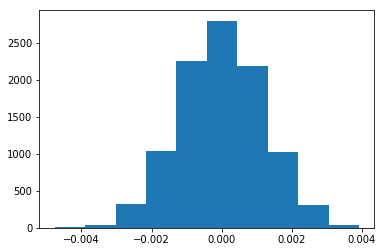

In [240]:
plt.hist(p_diffs)


j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [241]:
obs_diff= df2.query('group=="treatment"')['converted'].mean()- df2.query('group=="control"')['converted'].mean()
obs_diff

-0.0015782389853555567

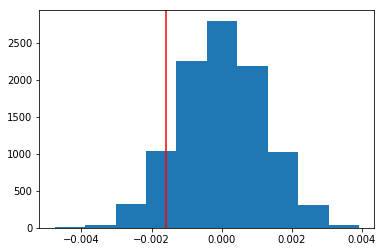

In [242]:
plt.hist(p_diffs)
plt.axvline(x=obs_diff,color='red')


In [243]:
(p_diffs > obs_diff).mean()

0.90580000000000005

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

As the null hypothesis suggests that the old page similar or better than the new page, the p-value will be the area of the distribution which is right to the observed difference in the original dataset.

The given Type I error rate is 5% and the p-value is greater than the error rate hence we fail to reject the null hypothesisi

**Put your answer here.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [244]:
import statsmodels.api as sm

convert_old = df2.query('group=="control" and converted==1').count()[0]
convert_new = df2.query('group=="treatment" and converted==1').count()[0]
n_old = df2.shape[0]
n_new = df2.shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [245]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_value

(1.2447321532209403, 0.89338488860036569)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Z-score**:  *The Z score is a test of statistical significance that helps you decide whether or not to reject the null hypothesis.*

**p-value**: *The p-value is the probability that you have falsely rejected the null hypothesis*

* The returned a Z score of +1.244 is interpreted as "1.244 standard deviations away from the mean"

* In this scenario, we are using a 95% confidence interval, as the maximum permissible type1 error rate is 0.05.

* The critical Z score values when using a 95% confidence level are -1.96 and +1.96 standard deviations. 

* The p-value associated with a 95% confidence level is 0.05. 

Since our Z score is between -1.96 and +1.96 (~1.244), and p-value is larger than 0.05 (~0.9), we fail to reject the null hypothesis

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Linear Regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [246]:
ab_page= pd.get_dummies(df['landing_page'])
df2= df2.join(ab_page)
df2= df2.rename(columns={'new_page':'ab_page'})
df2['intercept']=1
df2= df2.drop(columns=['landing_page'])
df2= df2.drop(columns=['old_page'])

In [247]:
df2.head()

,user_id,timestamp,group,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,1,0,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [248]:
lm=sm.OLS(df2['converted'],df2[['intercept','ab_page']])
result= lm.fit()

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [249]:

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.719
Date:                Tue, 12 May 2020   Prob (F-statistic):              0.190
Time:                        15:00:01   Log-Likelihood:                -85267.
No. Observations:              290584   AIC:                         1.705e+05
Df Residuals:                  290582   BIC:                         1.706e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1204      0.001    141.407      0.000       0.119       0.122
ab_page       -0.0016      0.001     -1.311      0.190      -0.004       0.001
==============================================================================
Omnibus:                   125553.456   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           414313.355
Skew:                           2.345   Prob(JB):                         0.00
Kurtosis:                       6.497   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  

The equation for linear regression in this case is

$$Y = Β_0 + Β_1X$$

$$X: ab_page, Y: conversion, & B_0: intercept$$

If there is a significant linear relationship between the independent variable  and the dependent variable Y, the slope will not equal zero.
Hence,

$$H_0: B_1 = 0$$


$$H_1: B_1 \neq 0$$


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**To make this model a multilinear regression model, we need to add more parameters for consideration.** 

* Addition of `group` is pointless as our data set consists of a new_page only when the group is a treatment group and similar for control group.

* Considering the timestamp is possible, especially when considering days and months. Certain regions have people from a certain belief/religion, and celebrate festivals which might last for a day or sometimes for weeks. It is possible that the conversions during these times increases due to many reasons. 
  
*Taking an example of the Indian customers during the festival of Diwali, the E-commerce business increases 4 time, and the number of customers also increases. Such a targeted approach is always beneficial, and considering timestamps can help understand the patterns if possible*

However, I feel this idea has a slight disadvantage as there is a possibility that as time passes, users from either of the groups might have come across similar changes from rival websites which might not convince them to convert. I might lead to certain bias in the data.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns -  Provide the statistical output as well as a written response to answer this question.

In [250]:
df3=pd.read_csv('countries.csv')
df3.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [251]:
df3.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [252]:
country_dummies = pd.get_dummies(df3['country'])
df3 = df3.join(country_dummies)

In [253]:
df3 = df2.set_index('user_id').join(df3.set_index('user_id'))
df3.head()

,timestamp,group,converted,ab_page,intercept,country,CA,UK,US
user_id,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,0,0,1,US,0,0,1
804228,2017-01-12 08:01:45.159739,control,0,0,1,US,0,0,1
661590,2017-01-11 16:55:06.154213,treatment,0,1,1,US,0,0,1
853541,2017-01-08 18:28:03.143765,treatment,0,1,1,US,0,0,1
864975,2017-01-21 01:52:26.210827,control,1,0,1,US,0,0,1


In [210]:
lm = sm.OLS(df3['converted'], df3[['intercept', 'UK', 'US']])
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.605
Date:                Tue, 12 May 2020   Prob (F-statistic):              0.201
Time:                        14:59:33   Log-Likelihood:                -85267.
No. Observations:              290584   AIC:                         1.705e+05
Df Residuals:                  290581   BIC:                         1.706e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1153      0.003     42.792      0.000       0.110       0.121
UK             0.0053      0.003      1.787      0.074      -0.001       0.011
US             0.0042      0.003      1.516      0.130      -0.001       0.010
==============================================================================
Omnibus:                   125552.384   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           414306.036
Skew:                           2.345   Prob(JB):                         0.00
Kurtosis:                       6.497   Cond. No.                         9.94
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

***Keeping 'CA' as the baseling and looking at the result summary of the model, both US and UK explanatory variables have an extremely small slope which means that keeping the other variables constant, for each unit change in 'UK' or 'US', the conversion rate is affected by only 0.0053 or 0.0042 respectively***

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [209]:
lm=sm.OLS(df3['converted'],df3[['intercept','ab_page','UK','US']])
results= lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.640
Date:                Tue, 12 May 2020   Prob (F-statistic):              0.178
Time:                        14:53:16   Log-Likelihood:                -85266.
No. Observations:              290584   AIC:                         1.705e+05
Df Residuals:                  290580   BIC:                         1.706e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1161      0.003     42.036      0.000       0.111       0.122
ab_page       -0.0016      0.001     -1.307      0.191      -0.004       0.001
UK             0.0053      0.003      1.784      0.074      -0.001       0.011
US             0.0042      0.003      1.514      0.130      -0.001       0.010
==============================================================================
Omnibus:                   125551.169   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           414297.780
Skew:                           2.345   Prob(JB):                         0.00
Kurtosis:                       6.497   Cond. No.                         10.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

At alpha=0.05, we notice that UK, US and ab_page are statistically significant. 
We fail to reject the null hypothesis (old_page better or equal to new page) due to the P-values being significantly lower than the threshold

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!


In [260]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0

<a id='references'></a>
## References

https://stackoverflow.com/questions/45575165/how-to-merge-overlapping-columns

https://stattrek.com/multiple-regression/dummy-variables.aspx

http://resources.esri.com/help/9.3/arcgisdesktop/com/gp_toolref/spatial_statistics_toolbox/what_is_a_z_score_what_is_a_p_value.htm

https://github.com/thomastt2020/Udacity-A-B-Test/blob/master/Analyze_ab_test_results_notebook.ipynb